In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pvlib
import datetime
import pprint
import os
import bifacial_radiance as br

In [2]:
path_parent = os.path.dirname(os.getcwd())
InputFilesFolder = os.path.join(path_parent,'InputFiles')
ResultsFolder = r'TEMP'
exampleflag = False
debugflag = False

In [3]:
import bifacialvf

# Print bifacialvf Version:
bifacialvf.__version__


'0.1.7-dev1+83.gc674b11.dirty'

In [4]:
plt.rcParams['timezone'] = 'Etc/GMT+7'
font = {'family' : 'DejaVu Sans',
'weight' : 'bold',
'size'   : 22}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (12, 5)

In [5]:
orga = pd.read_excel('..\Combinations.xlsx', skiprows = 20)
orga.fillna(method='ffill')

,Method,Sim,WeatherFile_Name,NOTES,DNI,DHI,GHI,POA,BOA,POABOA,...,AmbientTemperature,TrackerAngle,irrad_mod,sky_model,Module,Module Temperature,TestPOA,TestBOA,TestModuleTemp,TestPerformance
0,1,00,00,baseline,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
1,1,A01,A01,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
2,1,A02,A02,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
3,1,A03,A03,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
4,1,A04,A04,Test Albedo,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,Yes,Yes,Yes,Yes
5,1,W01,W01,Test Wind Speed,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,-,-,Yes,Yes
6,1,W02,W02,Test Wind Speed,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,-,-,Yes,Yes
7,1,W03,W03,Test Wind Speed,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,0,0,0,2,All tree,NaN,-,-,Yes,Yes
8,1,T01,T01,Test Temperature,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,1,0,0,2,All tree,NaN,-,-,Yes,Yes
9,1,T02,T02,Test Temperature,SRRL_DNI,SRRL_DHI,SRRL_GHI,0,0,0,...,2,0,0,2,All tree,NaN,-,-,Yes,Yes


In [6]:
InputFilesFolder = r'..\InputFiles'
ResultsFolder = r'Results'

### Retrieve module data from CEC database

In [7]:
db = pvlib.pvsystem.retrieve_sam(name='CECMod').T

# MODIFY THIS FOR YOUR TYPE OF MODULE
# 2-Bifi: Prism 457cBSTC
# 4-Bifi: LONGi Green Energy Technology Co._Ltd. LR6-72PH-370M
# 9-Bifi: Sunpreme Inc. SNPM-HxB-400

row2filter = db.index.str.startswith('Prism') & db.index.str.contains('457')
row2Mod = db[row2filter]

row4filter = db.index.str.startswith('LONGi') & db.index.str.contains('72PH_370')
row4Mod = db[row2filter]

row9filter = db.index.str.startswith('Sunpreme') & db.index.str.contains('400')
row9Mod = db[row9filter]

# Sanity check, in case the database gets updated and the module name slightly changes and doesn't find it. 
if len(row2Mod) != 1 or len(row4Mod) !=1 or len(row9Mod) !=1:
    print("Check filtering")

In [8]:
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
tpmBifiGG = ( TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']) # temperature_model_parameters 
tpmMonoBS = ( TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']) # temperature_model_parameters

In [9]:
### Set Field parameters

In [10]:
row2Mod.bifaciality = 0.694
row4Mod.bifaciality = 0.73
row9Mod.bifaciality = 0.87

In [11]:
row8Mod = row4Mod.copy()
row8Mod.keys()

Index(['Technology', 'Bifacial', 'STC', 'PTC', 'A_c', 'Length', 'Width', 'N_s',
       'I_sc_ref', 'V_oc_ref', 'I_mp_ref', 'V_mp_ref', 'alpha_sc', 'beta_oc',
       'T_NOCT', 'a_ref', 'I_L_ref', 'I_o_ref', 'R_s', 'R_sh_ref', 'Adjust',
       'gamma_r', 'BIPV', 'Version', 'Date'],
      dtype='object')

In [12]:
row8Mod['Bifacial'] = 0
row8Mod.bifaciality = 0
row8Mod.STC = 355.38
row8Mod.A_c = 1.91999995708466
row8Mod.Width = 1.0
row8Mod.Length = 1.91999

row8Mod.N_s = 72
row8Mod.I_sc_ref = 9.59000015258789
row8Mod.V_oc_ref = 46.79999923706055
row8Mod.I_mp_ref = 9.02000045776367
row8Mod.V_mp_ref = 39.40000152587891
row8Mod.alpha_sc = 0.00480500003323
row8Mod.beta_oc = -0.13684299588203
row8Mod.T_NOCT = 44.59999847412109

row8Mod.a_ref = 1.84059113052428
row8Mod.I_L_ref = 9.59636296770026
row8Mod.I_o_ref = 8.5526e-11
row8Mod.R_s = 0.192283260604
row8Mod.R_sh_ref = 289.8082846283974
row8Mod.Adjust = 10.70365729923
row8Mod.gamma_r = -0.38109999895096
row8Mod.PTC = (100+(row8Mod.T_NOCT-25)*row8Mod.gamma_r)*row8Mod.STC/100
row8Mod.PTC

Prism_Solar_Technologies_Bi72_457BSTC    328.83468
Name: PTC, dtype: float64

In [13]:
# Variables
tilt = 10                   # PV tilt (deg)
sazm = 180                  # PV Azimuth(deg) or tracker axis direction
albedo = None               # Calculated in previous section from SRRL data. Value is 0.28 up to 11/18/19o
hub_height=1.5/2            #1.5m / 2m collector width
pitch = 2/0.35/2              # 1 / 0.35 where 0.35 is gcr --- row to row spacing in normalized panel lengths. 
rowType = "interior"        # RowType(first interior last single)
transFactor = 0             # TransmissionFactor(open area fraction)
sensorsy = 12                # sensorsy(# hor rows in panel)   <--> THIS ASSUMES LANDSCAPE ORIENTATION 
PVfrontSurface = "glass"    # PVfrontSurface(glass or ARglass)
PVbackSurface = "glass"     # PVbackSurface(glass or ARglass)

 # Calculate PV Output Through Various Methods    
calculateBilInterpol = False   # Only works with landscape at the moment.
calculatePVMismatch = False
portraitorlandscape='portrait'   # portrait or landscape
cellsnum = 72
bififactor = 1.0

# Tracking instructions
tracking=True
backtrack=True
limit_angle = 50

### POA to Performance

In [14]:
def calculatePerformance(effective_irradiance, temp_cell, CECMod):
    r'''
    The module parameters are given at the reference condition. 
    Use pvlib.pvsystem.calcparams_cec() to generate the five SDM 
    parameters at your desired irradiance and temperature to use 
    with pvlib.pvsystem.singlediode() to calculate the IV curve information.:
    
    Inputs
    ------
    df : dataframe
        Dataframe with the 'effective_irradiance' columns and 'temp_cell'
        columns.
    CECMod : Dict
        Dictionary with CEC Module PArameters for the module selected. Must 
        contain at minimum  alpha_sc, a_ref, I_L_ref, I_o_ref, R_sh_ref,
        R_s, Adjust
    '''
    
    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(
        effective_irradiance=effective_irradiance,
        temp_cell=temp_cell,
        alpha_sc=float(CECMod.alpha_sc),
        a_ref=float(CECMod.a_ref),
        I_L_ref=float(CECMod.I_L_ref),
        I_o_ref=float(CECMod.I_o_ref),
        R_sh_ref=float(CECMod.R_sh_ref),
        R_s=float(CECMod.R_s),
        Adjust=float(CECMod.Adjust)
        )
    
    IVcurve_info = pvlib.pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth 
        )
    
    return IVcurve_info['p_mp']


In [20]:
dfAll = pd.DataFrame()

for ii in range(0, len(orga)): # loop here over all the weather files or sims.

    print(ii)
    weatherfile = os.path.join(InputFilesFolder,'WF_SAM_'+orga.loc[ii]['WeatherFile_Name']+'.csv')
    savefilevar = os.path.join(ResultsFolder,'Results_pySAM_'+orga.loc[ii]['Sim']+'.csv')

    myTMY3, meta = bifacialvf.bifacialvf.readWeatherFile(weatherfile, source='SAM')
    # myTMY3, meta = bifacialvf.bifacialvf.fixintervalTMY(myTMY3,meta)  # Use if data resolution is diff. than hourly

    if orga.loc[ii]['irrad_mod'] < 3:
        bifacialvf.simulate(myTMY3, meta, writefiletitle=savefilevar, 
                         tilt=tilt, sazm=sazm, pitch=pitch, hub_height=hub_height, 
                         rowType=rowType, transFactor=transFactor, sensorsy=sensorsy, 
                         PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface,
                         albedo=albedo, tracking=tracking, backtrack=backtrack, 
                         limit_angle=limit_angle, calculatePVMismatch=calculatePVMismatch,
                         cellsnum = cellsnum, bififactor=bififactor,
                         calculateBilInterpol=calculateBilInterpol,
                         portraitorlandscape=portraitorlandscape,
                         deltastyle='SAM')

        data, meta = bifacialvf.loadVFresults(savefilevar)

        filter_col = [col for col in data if col.endswith('FrontGTI')]
        data['Front2489'] = data[filter_col].mean(axis=1)

        filter_col = [col for col in data if col.endswith('RowBackGTI')]
        data['Rear249'] = data[filter_col].mean(axis=1)

        data['EffectivePOABOA_2'] = data['Front2489'] + row2Mod.bifaciality * data['Rear249']
        data['EffectivePOABOA_4'] = data['Front2489'] + row4Mod.bifaciality * data['Rear249']
        data['EffectivePOA_8'] = data['Front2489']
        data['EffectivePOABOA_9'] = data['Front2489'] + row9Mod.bifaciality * data['Rear249']

    # System takes POA values and just calculates performance
    # TODO: Also pass cell temperature?
    else:
        
        data['EffectivePOABOA_2'] = myTMY3['POA']
        data['EffectivePOABOA_4'] = myTMY3['POA']
        data['EffectivePOA_8'] = myTMY3['POA']
        data['EffectivePOABOA_9'] = myTMY3['POA']
        data['Front2489'] = np.nan
        data['Rear249'] = np.nan

    data['CellTemp2'] = pvlib.temperature.sapm_cell(data.EffectivePOABOA_2, data.Tamb, data.VWind, tpmBifiGG['a'], 
                                                tpmBifiGG['b'], tpmBifiGG['deltaT'])
    data['CellTemp4'] = pvlib.temperature.sapm_cell(data.EffectivePOABOA_4, data.Tamb, data.VWind, 
                                                    tpmBifiGG['a'], tpmBifiGG['b'], tpmBifiGG['deltaT'])
    data['CellTemp9'] = pvlib.temperature.sapm_cell(data.EffectivePOABOA_9, data.Tamb, data.VWind, 
                                                    tpmBifiGG['a'], tpmBifiGG['b'], tpmBifiGG['deltaT'])
    data['CellTemp8'] = pvlib.temperature.sapm_cell(data.EffectivePOA_8, data.Tamb, data.VWind, tpmMonoBS['a'], 
                                                    tpmMonoBS['b'], tpmMonoBS['deltaT'])

    # br.performance.calculatePerformance also calculates cell temperature but doesn't report it, so 
    # doing it explicitly here.
    data['Power2'] = br.performance.calculatePerformance(effective_irradiance = data.EffectivePOABOA_2,
                                                           CECMod = row2Mod,
                                                           temp_cell = data['CellTemp2'])
    data['Power4'] = br.performance.calculatePerformance(effective_irradiance = data.EffectivePOABOA_4,
                                                           CECMod = row4Mod,
                                                           temp_cell = data['CellTemp4'])
    data['Power8'] = br.performance.calculatePerformance(effective_irradiance = data.EffectivePOA_8,
                                                           CECMod = row8Mod,
                                                           temp_cell = data['CellTemp8'])
    data['Power9'] = br.performance.calculatePerformance(effective_irradiance = data.EffectivePOABOA_9,
                                                           CECMod = row9Mod,
                                                           temp_cell = data['CellTemp9'])
    data['Sim'] = orga.loc[ii]['Sim']
    res = data[['Sim', 'Power2', 'CellTemp2', 'Rear249', 'Front2489', 'Power4', 'CellTemp4', 'Power8', 'CellTemp8', 
                'Power9', 'CellTemp9', 'dni', 'dhi', 'albedo']]

    res['index'] = res.index
    res['datetimes'] = list(pd.to_datetime(data['date']))
    res['Year'] = list(res['datetimes'].dt.year)
    res['Month'] = list(res['datetimes'].dt.month)
    res['Hour'] = list(res['datetimes'].dt.hour)
    
    res['Power2']= res['Power2']/row2Mod.STC[0]
    res['Power4']= res['Power4']/row4Mod.STC[0]
    res['Power8']= res['Power8']/row8Mod.STC[0]
    res['Power9']= res['Power9']/row9Mod.STC[0]
    
    res.to_pickle('Sim_'+orga.loc[ii]['Sim']+'.pkl')
    dfAll = pd.concat([dfAll, res], ignore_index=True, axis=0)

dfAll.to_pickle('Results_bifacialVFpvlib.pkl')


0
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_00.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:56<00:00, 155.75it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

1
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_A01.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:56<00:00, 156.28it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

2
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_A02.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:55<00:00, 157.08it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

3
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_A03.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:55<00:00, 157.22it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

4
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_A04.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:55<00:00, 156.45it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

5
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_W01.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:56<00:00, 155.09it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

6
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_W02.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:56<00:00, 156.18it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

7
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_W03.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:55<00:00, 158.63it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

8
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_T01.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:54<00:00, 159.63it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

9
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_T02.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:54<00:00, 159.63it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

10
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_T03.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:54<00:00, 159.93it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

11
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_T04.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:54<00:00, 159.55it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

12
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_S01.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:54<00:00, 160.06it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

13
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_S02.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:56<00:00, 155.70it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

14
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_S03.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:58<00:00, 150.26it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

15
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_S04.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:56<00:00, 155.28it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

16
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_S05.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:56<00:00, 155.77it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

17
Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
Using albedo from Weather File file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for Weather File: 
Location:   DENVER/CENTENNIAL [GOLDEN - NREL]
Lat:  39.742  Long:  -105.179  Tz  -7
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into Results\Results_pySAM_S07.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 *** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:55<00:00, 156.75it/s]
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


Finished


C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\Documents\GitHub\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

18
19
20


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

21
22
23


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

24
25
26


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

27
28


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Year'] = list(res['datetimes'].dt.year)
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Month'] = list(res['datetimes'].dt.month)
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

29
30
31


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Year'] = list(res['datetimes'].dt.year)
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

32
33
34


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

35
36
37


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

38
39
40


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

41
42
43


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

44
45
46


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['index'] = res.index
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['datetimes'] = list(pd.to_datetime(data['date']))
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_24696\1593144902.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

47
48


In [19]:
row2Mod.STC[0]

360.214

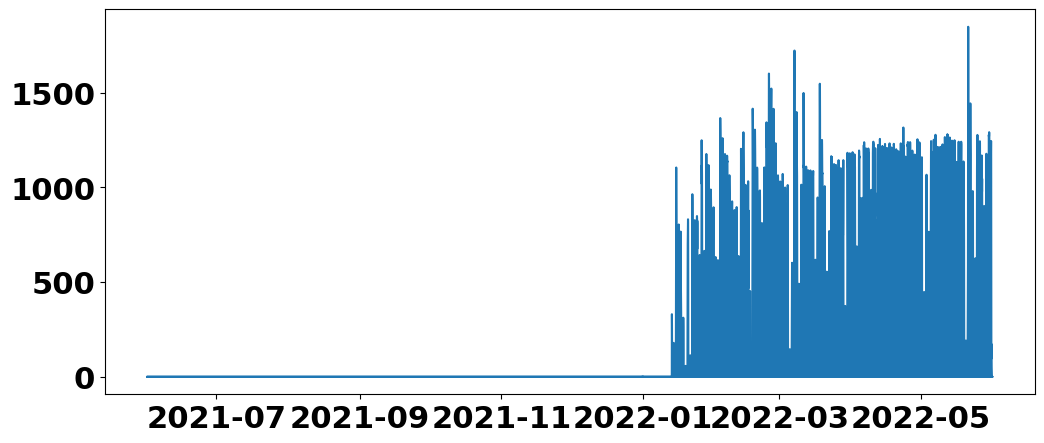

In [21]:
plt.plot(myTMY3['POA'])

In [ ]:
dfAll

In [ ]:
wftimestamp, meta = pvlib.iotools.read_psm3(os.path.join(InputFilesFolder,'WF_SAM_'+orga.loc[0]['WeatherFile_Name']+'.csv'))
datelist = list(wftimestamp.index) 
datelist